# 数据下载

In [1]:
import os
os.listdir()

['trans.ipynb',
 'README.md',
 'MNIST_data',
 '.ipynb_checkpoints',
 'fashion.ipynb',
 'FashionMNIST',
 't.sh',
 'transformer_learn.py']

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
# 对图片数据进行转换，因为Fashion minist是灰度图，所以使用下面的normalization方式
transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [4]:
# 数据下载与封装
train_set = datasets.FashionMNIST('./', download = True, train = True, transform = transform)
test_set = datasets.FashionMNIST('./', download = True, train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = True)

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
# 检查数据
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


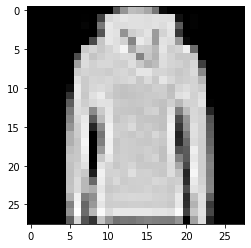

In [7]:
plt.imshow(images[5].numpy().squeeze(), cmap = 'Greys_r')

# DNN神经网络

In [34]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
# NLLLoss 是似然损失函数的一种，参考：https://zhuanlan.zhihu.com/p/83283586
# 常用在分类任务中
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    model.train()
    for images, labels in train_loader:
    # Flatten Fashion-MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)
            
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
          "Test loss: {:.3f}..".format(test_loss/len(test_loader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30.. Training loss: 0.597.. Test loss: 0.450.. Test Accuracy: 0.831
Epoch: 2/30.. Training loss: 0.453.. Test loss: 0.442.. Test Accuracy: 0.839
Epoch: 3/30.. Training loss: 0.419.. Test loss: 0.401.. Test Accuracy: 0.856
Epoch: 4/30.. Training loss: 0.398.. Test loss: 0.374.. Test Accuracy: 0.867
Epoch: 5/30.. Training loss: 0.389.. Test loss: 0.375.. Test Accuracy: 0.868
Epoch: 6/30.. Training loss: 0.373.. Test loss: 0.396.. Test Accuracy: 0.855
Epoch: 7/30.. Training loss: 0.365.. Test loss: 0.385.. Test Accuracy: 0.861
Epoch: 8/30.. Training loss: 0.358.. Test loss: 0.370.. Test Accuracy: 0.869
Epoch: 9/30.. Training loss: 0.349.. Test loss: 0.358.. Test Accuracy: 0.877
Epoch: 10/30.. Training loss: 0.341.. Test loss: 0.363.. Test Accuracy: 0.876
Epoch: 11/30.. Training loss: 0.335.. Test loss: 0.360.. Test Accuracy: 0.872
Epoch: 16/30.. Training loss: 0.316.. Test loss: 0.356.. Test Accuracy: 0.876
Epoch: 17/30.. Training loss: 0.314.. Test loss: 0.369.. Test Accuracy: 0

# Resnet神经网络

In [27]:
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [11]:
model = torchvision.models.resnet18(pretrained=True)

In [21]:
# TODO:这里的7,7尺寸是什么？
for name, layer in model.named_modules():
    if isinstance(layer, nn.MaxPool2d):
        model.maxpool = nn.AdaptiveAvgPool2d((7, 7))
# 因为数据集是10分类，所以这里设置为10
model.fc.out_features = 10

In [29]:
# 因为resnet不进行修改的话，只能用于彩色图片，所以这里要对数据进行处理
# 我们可以在前面加个卷积核，将通道映射到3，然后输入到resnet中, 也可以直接修改resnet第一层通道为1
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))

In [30]:
# 检查模型是否可以自适应了，发现已经替换完成
# 查看模型, 因为resnet模型对输入的图片尺寸有要求，所以这里要改成自适应
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

In [33]:
batch_size = 128
epochs = 30
lr = 0.001
gamma = 0.9
step_size=5

device_count = torch.cuda.device_count()
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

if device_count > 1:
    model = nn.DataParallel(model,device_ids=range(device_count)) # multi-GPU
    model.to(device)

else:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式

# 训练模型
train_acc, test_acc = [], []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
        output = model(data)
    
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        data.cpu()
        label.cpu()
        
    with torch.no_grad():
        epoch_test_accuracy = 0
        epoch_test_loss = 0
        for data, label in tqdm(test_loader):
            data = data.cuda()
            label = label.cuda()
            
            test_output = model(data)
            test_loss = criterion(test_output, label)
            
            acc = (test_output.argmax(dim=1) == label).float().mean()
            epoch_test_accuracy += acc / len(test_loader)
            epoch_test_loss += test_loss / len(test_loader)
            data.cpu()
            label.cpu()
    scheduler.step()
    
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'test loss:{epoch_test_loss:.4f}, test acc:{epoch_test_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    test_acc.append(epoch_test_accuracy)

  0%|          | 4/938 [00:00<00:30, 31.05it/s]

EPOCH: 0, train loss:0.3041, train acc:0.8911
test loss:0.3176, test acc:0.8881


  0%|          | 4/938 [00:00<00:29, 31.79it/s]

EPOCH: 1, train loss:0.2453, train acc:0.9100
test loss:0.2984, test acc:0.8921


  0%|          | 3/938 [00:00<00:31, 29.96it/s]

EPOCH: 2, train loss:0.2545, train acc:0.9079
test loss:0.2772, test acc:0.9005


  0%|          | 4/938 [00:00<00:29, 31.53it/s]

EPOCH: 3, train loss:0.2067, train acc:0.9239
test loss:0.2790, test acc:0.9062


  0%|          | 4/938 [00:00<00:29, 31.44it/s]

EPOCH: 4, train loss:0.1901, train acc:0.9300
test loss:0.2726, test acc:0.9089


  0%|          | 4/938 [00:00<00:29, 31.60it/s]

EPOCH: 5, train loss:0.1629, train acc:0.9398
test loss:0.2578, test acc:0.9101


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 6, train loss:0.1351, train acc:0.9497
test loss:0.2674, test acc:0.9123


  0%|          | 4/938 [00:00<00:29, 31.89it/s]

EPOCH: 7, train loss:0.1116, train acc:0.9574
test loss:0.2770, test acc:0.9104


  0%|          | 4/938 [00:00<00:29, 31.75it/s]

EPOCH: 8, train loss:0.0979, train acc:0.9629
test loss:0.3160, test acc:0.8997


  0%|          | 4/938 [00:00<00:29, 31.77it/s]

EPOCH: 9, train loss:0.0835, train acc:0.9688
test loss:0.3152, test acc:0.9152


  0%|          | 4/938 [00:00<00:29, 31.84it/s]

EPOCH:10, train loss:0.0583, train acc:0.9784
test loss:0.3251, test acc:0.9165


  0%|          | 4/938 [00:00<00:29, 31.70it/s]

EPOCH:11, train loss:0.0471, train acc:0.9827
test loss:0.3519, test acc:0.9183


  0%|          | 4/938 [00:00<00:29, 31.79it/s]

EPOCH:12, train loss:0.0362, train acc:0.9870
test loss:0.3867, test acc:0.9177


  0%|          | 3/938 [00:00<00:31, 29.54it/s]

EPOCH:13, train loss:0.0315, train acc:0.9886
test loss:0.4099, test acc:0.9190


  0%|          | 4/938 [00:00<00:29, 31.17it/s]

EPOCH:14, train loss:0.0212, train acc:0.9924
test loss:0.4525, test acc:0.9168


  0%|          | 4/938 [00:00<00:29, 31.35it/s]

EPOCH:15, train loss:0.0169, train acc:0.9941
test loss:0.4839, test acc:0.9173


  0%|          | 3/938 [00:00<00:31, 29.31it/s]

EPOCH:16, train loss:0.0143, train acc:0.9948
test loss:0.4798, test acc:0.9161


  0%|          | 4/938 [00:00<00:29, 31.83it/s]

EPOCH:17, train loss:0.0094, train acc:0.9967
test loss:0.5085, test acc:0.9200


  0%|          | 4/938 [00:00<00:29, 31.73it/s]

EPOCH:18, train loss:0.0080, train acc:0.9971
test loss:0.5224, test acc:0.9190


  0%|          | 3/938 [00:00<00:35, 26.49it/s]

EPOCH:19, train loss:0.0066, train acc:0.9978
test loss:0.5896, test acc:0.9194


  0%|          | 3/938 [00:00<00:33, 27.74it/s]

EPOCH:20, train loss:0.0061, train acc:0.9983
test loss:0.6530, test acc:0.9191


  0%|          | 3/938 [00:00<00:32, 28.42it/s]

EPOCH:21, train loss:0.0044, train acc:0.9986
test loss:0.6422, test acc:0.9179


  0%|          | 3/938 [00:00<00:32, 28.63it/s]

EPOCH:22, train loss:0.0018, train acc:0.9995
test loss:0.6614, test acc:0.9195


  0%|          | 3/938 [00:00<00:32, 28.35it/s]

EPOCH:23, train loss:0.0036, train acc:0.9990
test loss:0.6434, test acc:0.9183


  0%|          | 3/938 [00:00<00:32, 28.48it/s]

EPOCH:24, train loss:0.0025, train acc:0.9993
test loss:0.6562, test acc:0.9206


  0%|          | 3/938 [00:00<00:32, 28.39it/s]

EPOCH:25, train loss:0.0015, train acc:0.9996
test loss:0.6939, test acc:0.9214


  0%|          | 3/938 [00:00<00:33, 27.94it/s]

EPOCH:26, train loss:0.0018, train acc:0.9994
test loss:0.6994, test acc:0.9210


  0%|          | 4/938 [00:00<00:29, 31.80it/s]

EPOCH:27, train loss:0.0011, train acc:0.9997
test loss:0.7040, test acc:0.9184


  0%|          | 3/938 [00:00<00:33, 28.21it/s]

EPOCH:28, train loss:0.0009, train acc:0.9997
test loss:0.7510, test acc:0.9215


100%|██████████| 157/157 [00:01<00:00, 78.67it/s]

EPOCH:29, train loss:0.0005, train acc:0.9998
test loss:0.7725, test acc:0.9203


# LSTM神经网络

In [ ]:
# LSTM做图像分类的原理是什么？


In [27]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py 
# http://colah.github.io/posts/2015-08-Understanding-LSTMs/
# 参考：https://zhuanlan.zhihu.com/p/79064602
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.optim as optim

In [13]:
# 使用LSTM的思路
# 把图片看成一个个句子，图片的尺寸为28*28，图片的长28相当于28个单词，图片的宽28相当于每个单词的向量长度
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 30
learning_rate = 0.01
gamma = 0.9
step_size=5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 官网默认的输入是seq_len, batch, input_size,这里将batch first=True放在第一个
        # seq len 相当于一句话的长度， input size相当于每个单词的向量长度
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # 初始化两个向量的值, 因为这里是两层的lstm
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # 前向传播，这里只需要out即可
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # 使用全连层进行分类
        out = self.fc(out[:, -1, :])
        return out
    
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式
# Train the model
total_step = len(train_loader)
train_acc, test_acc = [], []
for epoch in range(num_epochs):
    epoch_accuracy = 0
    epoch_loss = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # reshape的维度变成了(batch size, 28, 28)
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    # Test the model
    model.eval()
    with torch.no_grad():
        epoch_test_accuracy = 0
        epoch_test_loss = 0
        for images, labels in tqdm(test_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).float().mean()
            epoch_test_accuracy += acc / len(test_loader)

    scheduler.step()
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'test acc:{epoch_test_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    test_acc.append(epoch_test_accuracy)

  1%|          | 6/938 [00:00<00:15, 58.28it/s]

EPOCH: 0, train loss:0.6564, train acc:0.7587
test acc:0.8299


  1%|          | 6/938 [00:00<00:17, 53.01it/s]

EPOCH: 1, train loss:0.4203, train acc:0.8458
test acc:0.8494


  1%|          | 6/938 [00:00<00:15, 58.96it/s]

EPOCH: 2, train loss:0.3625, train acc:0.8664
test acc:0.8565


  1%|          | 6/938 [00:00<00:17, 54.02it/s]

EPOCH: 3, train loss:0.3302, train acc:0.8774
test acc:0.8729


  1%|          | 6/938 [00:00<00:17, 52.39it/s]

EPOCH: 4, train loss:0.3012, train acc:0.8884
test acc:0.8775


  1%|          | 6/938 [00:00<00:17, 54.81it/s]

EPOCH: 5, train loss:0.2803, train acc:0.8960
test acc:0.8844


  1%|          | 6/938 [00:00<00:18, 51.07it/s]

EPOCH: 6, train loss:0.2610, train acc:0.9027
test acc:0.8853


  1%|          | 6/938 [00:00<00:16, 55.76it/s]

EPOCH: 7, train loss:0.2401, train acc:0.9115
test acc:0.8874


  1%|          | 6/938 [00:00<00:17, 53.94it/s]

EPOCH: 8, train loss:0.2197, train acc:0.9192
test acc:0.8925


  1%|          | 6/938 [00:00<00:16, 56.10it/s]

EPOCH: 9, train loss:0.2030, train acc:0.9250
test acc:0.8933


  1%|          | 6/938 [00:00<00:17, 53.96it/s]

EPOCH:10, train loss:0.1806, train acc:0.9321
test acc:0.8999


  1%|          | 6/938 [00:00<00:17, 52.73it/s]

EPOCH:11, train loss:0.1614, train acc:0.9399
test acc:0.8984


  1%|          | 6/938 [00:00<00:18, 50.86it/s]

EPOCH:12, train loss:0.1447, train acc:0.9461
test acc:0.9006


  1%|          | 6/938 [00:00<00:17, 53.45it/s]

EPOCH:13, train loss:0.1255, train acc:0.9540
test acc:0.9020


  1%|          | 5/938 [00:00<00:19, 46.97it/s]

EPOCH:14, train loss:0.1085, train acc:0.9601
test acc:0.9030


  1%|          | 6/938 [00:00<00:17, 54.36it/s]

EPOCH:15, train loss:0.0916, train acc:0.9674
test acc:0.9032


  1%|          | 6/938 [00:00<00:16, 56.06it/s]

EPOCH:16, train loss:0.0751, train acc:0.9737
test acc:0.8995


  1%|          | 6/938 [00:00<00:15, 59.38it/s]

EPOCH:17, train loss:0.0628, train acc:0.9788
test acc:0.9005


  1%|          | 6/938 [00:00<00:16, 56.57it/s]

EPOCH:18, train loss:0.0507, train acc:0.9841
test acc:0.9031


  1%|          | 6/938 [00:00<00:16, 55.79it/s]

EPOCH:19, train loss:0.0409, train acc:0.9878
test acc:0.9034


  1%|          | 6/938 [00:00<00:16, 58.09it/s]

EPOCH:20, train loss:0.0315, train acc:0.9913
test acc:0.9025


  1%|          | 7/938 [00:00<00:15, 60.37it/s]

EPOCH:21, train loss:0.0251, train acc:0.9933
test acc:0.9037


  1%|          | 6/938 [00:00<00:16, 56.73it/s]

EPOCH:22, train loss:0.0186, train acc:0.9956
test acc:0.9028


  1%|          | 6/938 [00:00<00:18, 51.66it/s]

EPOCH:23, train loss:0.0138, train acc:0.9971
test acc:0.9024


  1%|          | 5/938 [00:00<00:18, 49.56it/s]

EPOCH:24, train loss:0.0101, train acc:0.9983
test acc:0.9003


  1%|          | 6/938 [00:00<00:16, 56.30it/s]

EPOCH:25, train loss:0.0090, train acc:0.9986
test acc:0.8999


  1%|          | 6/938 [00:00<00:17, 53.78it/s]

EPOCH:26, train loss:0.0059, train acc:0.9992
test acc:0.9019


  1%|          | 6/938 [00:00<00:16, 55.02it/s]

EPOCH:27, train loss:0.0057, train acc:0.9991
test acc:0.9014


  1%|          | 6/938 [00:00<00:17, 52.01it/s]

EPOCH:28, train loss:0.0040, train acc:0.9995
test acc:0.9011


100%|██████████| 157/157 [00:01<00:00, 78.81it/s]

EPOCH:29, train loss:0.0033, train acc:0.9997
test acc:0.9000


# Transformer网络

In [13]:
# https://bitjoy.net/2019/08/02/cs224n%ef%bc%881-31%ef%bc%89translation-seq2seq-attention/
# https://bitjoy.net/2020/03/04/cs224n%ef%bc%882-21%ef%bc%89transformers-and-self-attention-for-generative-models/
# https://zhuanlan.zhihu.com/p/48731949
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torch
import math

In [84]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=28, max_len=28):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]        

In [136]:
class Transformer(nn.Module):
    # 这里feature size必须可以整除以nhead
    def __init__(self, feature_size=28, num_layers=3, nhead=7):
        super().__init__()
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size).to(device)
        self.nhead = nhead
        self.feature_size = feature_size
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=self.nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size**2, 10)
        self.init_weight()
        
    def forward(self, x):
        if self.src_mask is None:
            mask = self._generate_square_subsequent_mask(len(x)).to(device)
            self.src_mask = mask
        x = self.pos_encoder(x)    
        x = self.transformer_encoder(x, self.src_mask)
        x = self.decoder(x.permute(1, 0, 2).reshape(-1, self.feature_size**2))
        return x
    
   # 将decoder 的偏置转换成0， 将权重进行标准化 
    def init_weight(self):
        self.decoder.bias.data.zero_()
        
   # 将输入的序列进行mask操作 
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [137]:
model = Transformer().to(device)

In [138]:
batch_size = 100
num_epochs = 30
learning_rate = 0.001
gamma = 0.9
step_size=1

In [139]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma) # 学习方式
# Train the model
total_step = len(train_loader)
train_acc, test_acc = [], []
# seq_len 相当于 max len， 即每句话切分的最大长度
sequence_length = 28
# input_size 相当于embedding dim
input_size = 28
for epoch in range(num_epochs):
    epoch_accuracy = 0
    epoch_loss = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # reshape的维度变成了(batch size, 28, 28)
        images = images.reshape(-1, sequence_length, input_size)
        images = images.permute(1, 0, 2).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    # Test the model
    model.eval()
    with torch.no_grad():
        epoch_test_accuracy = 0
        epoch_test_loss = 0
        for images, labels in tqdm(test_loader):
            images = images.reshape(-1, sequence_length, input_size)
            images = images.permute(1, 0, 2).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).float().mean()
            epoch_test_accuracy += acc / len(test_loader)

    scheduler.step()
    print(f'EPOCH:{epoch:2}, train loss:{epoch_loss:.4f}, train acc:{epoch_accuracy:.4f}')
    print(f'test acc:{epoch_test_accuracy:.4f}')

    train_acc.append(epoch_accuracy)
    test_acc.append(epoch_test_accuracy)

  1%|          | 5/938 [00:00<00:20, 45.69it/s]

EPOCH: 0, train loss:0.4778, train acc:0.8260
test acc:0.8542


  1%|          | 5/938 [00:00<00:21, 42.49it/s]

EPOCH: 1, train loss:0.3591, train acc:0.8700
test acc:0.8720


  1%|          | 5/938 [00:00<00:21, 43.33it/s]

EPOCH: 2, train loss:0.3222, train acc:0.8818
test acc:0.8797


  1%|          | 5/938 [00:00<00:20, 45.05it/s]

EPOCH: 3, train loss:0.2953, train acc:0.8914
test acc:0.8799


  1%|          | 5/938 [00:00<00:22, 41.68it/s]

EPOCH: 4, train loss:0.2744, train acc:0.8985
test acc:0.8927


  1%|          | 5/938 [00:00<00:21, 43.41it/s]

EPOCH: 5, train loss:0.2569, train acc:0.9055
test acc:0.8931


  1%|          | 5/938 [00:00<00:20, 44.68it/s]

EPOCH: 6, train loss:0.2430, train acc:0.9089
test acc:0.8947


  1%|          | 5/938 [00:00<00:20, 44.83it/s]

EPOCH: 7, train loss:0.2258, train acc:0.9168
test acc:0.8953


  1%|          | 6/938 [00:00<00:18, 51.73it/s]

EPOCH: 8, train loss:0.2151, train acc:0.9193
test acc:0.8997


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 9, train loss:0.2031, train acc:0.9249
test acc:0.8997


  1%|          | 6/938 [00:00<00:16, 55.68it/s]

EPOCH:10, train loss:0.1911, train acc:0.9294
test acc:0.8982


  1%|          | 5/938 [00:00<00:22, 40.94it/s]

EPOCH:11, train loss:0.1803, train acc:0.9329
test acc:0.9027


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:12, train loss:0.1703, train acc:0.9367
test acc:0.9064


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:13, train loss:0.1604, train acc:0.9394
test acc:0.9078


  1%|          | 5/938 [00:00<00:21, 43.51it/s]

EPOCH:14, train loss:0.1534, train acc:0.9438
test acc:0.9062


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:15, train loss:0.1452, train acc:0.9461
test acc:0.9051


  1%|          | 5/938 [00:00<00:22, 40.95it/s]

EPOCH:16, train loss:0.1387, train acc:0.9486
test acc:0.9045


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:17, train loss:0.1332, train acc:0.9512
test acc:0.9042


  1%|          | 5/938 [00:00<00:21, 43.66it/s]

EPOCH:18, train loss:0.1264, train acc:0.9540
test acc:0.9071


  1%|          | 5/938 [00:00<00:20, 46.29it/s]

EPOCH:19, train loss:0.1190, train acc:0.9560
test acc:0.9078


  1%|          | 5/938 [00:00<00:22, 41.90it/s]

EPOCH:20, train loss:0.1160, train acc:0.9573
test acc:0.9064


  1%|          | 5/938 [00:00<00:20, 45.84it/s]

EPOCH:21, train loss:0.1106, train acc:0.9589
test acc:0.9064


  1%|          | 5/938 [00:00<00:20, 44.96it/s]

EPOCH:22, train loss:0.1078, train acc:0.9604
test acc:0.9084


  1%|          | 5/938 [00:00<00:21, 42.61it/s]

EPOCH:23, train loss:0.1040, train acc:0.9611
test acc:0.9061


  1%|          | 5/938 [00:00<00:22, 41.18it/s]

EPOCH:24, train loss:0.1011, train acc:0.9629
test acc:0.9070


  1%|          | 5/938 [00:00<00:18, 49.85it/s]

EPOCH:25, train loss:0.0975, train acc:0.9633
test acc:0.9087


  1%|          | 6/938 [00:00<00:17, 54.79it/s]

EPOCH:26, train loss:0.0962, train acc:0.9649
test acc:0.9092


  1%|          | 7/938 [00:00<00:15, 61.36it/s]

EPOCH:27, train loss:0.0925, train acc:0.9668
test acc:0.9083


  1%|          | 5/938 [00:00<00:21, 43.95it/s]

EPOCH:28, train loss:0.0893, train acc:0.9675
test acc:0.9085


100%|██████████| 157/157 [00:01<00:00, 101.87it/s]

EPOCH:29, train loss:0.0882, train acc:0.9676
test acc:0.9081


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
model = Transformer().to(device)

In [59]:
model(d).shape

torch.Size([28, 64, 10])

In [96]:
torch.randn(3, 2).unsqueeze(1).expand(-1, 2, -1).shape

torch.Size([3, 2, 2])